https://colab.research.google.com/drive/1aoZYFabphLsPtpmiteSMevAOZ6nU1QEX?usp=sharing

Using tensorflow with keras and some other libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

Quinlan,Quinlan. Credit Approval. UCI Machine Learning Repository. https://doi.org/10.24432/C5FS30.

## Data Preperation

In [ ]:
# Read cols A1 - A16
cols = ['A' + str(i) for i in range(1,17)]
df = pd.read_csv("crx.data", names=cols)
# Convert target to 1 or 0
df["A16"] = (df["A16"] == '+').astype(int)
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


**Data Cleaning**
*   Missing Values - Filter out samples with missing values
  * I chose not to try to fill in missing values because this dataset is very unclear about the meanings of these values and some values are not numerical. I decided to simply filter them out so that they would not interfere with the process.


*   Data Correction
  *   After analyzing the data types in preparation to work with them, I noticed that two of the column's types are 'o' or object (column A2 and A14) when, according to the source of the data listed above, they should be numerical. I will convert these columns to a float and an int to match the intended data values.

  *   Some of the columns are intentionally of type 'o' or object. They use strings to represent states or values, however they are not meant to be interpreted as words. I will convert them to numbers so that they will  work with the model.


*   Outliers
  *   I will filter out the outliers for each numerical column to improve accuracy.





In [ ]:
# Filter out all rows with missing values (where value is '?' in this dataset)
df = df[(df['A1'] != '?') & (df['A2'] != '?') & (df['A4'] != '?') & (df['A5'] != '?') & (df['A6'] != '?') & (df['A7'] != '?') & (df['A14' ]!= '?')]

In [ ]:
# A2 and A14 columns are meant to be continous but are read as object types
# Convert them to float and int
df['A2'] = df['A2'].astype(float)
df['A14'] = df['A14'].astype(int)

In [ ]:
# Convert 'object' type columns to 'int' type columns
# Replace string values with numbers
for col in df.columns[:-1]:
  if df[col].dtypes == 'object':
    uniques = df[col].unique()
    for row in df.index:
      df.loc[row, col] = np.where(uniques == df.loc[row,col])[0][0]
    df[col] = df[col].astype(int)

In [ ]:
# Find outliers with z-score and drop
for col in df.columns[:-1]:
  if df[col].dtypes == 'int64' or df[col].dtypes == 'float64':
    mean = df[col].mean()
    std = df[col].std()
    for row in df.index:
      value = df.loc[row,col]
      zscore = (value - mean) / std
      if abs(zscore) > 3:
        df.drop(row, inplace=True)

**Training, Validation, and Testing Data** - Divide into 60% for training, 20% for validation, and 20% for testing

In [ ]:
# Train, Validation, and Test Data
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

**Preparing the data for use**

*   Scale numerical values to improve accuracy. Only use the columns specified by the data source as continuous and leave out the categorical columns even though they have been converted to number format.
*   Oversample to reduce class imbalance.



In [ ]:
# Data Preparation
def prepare_dataset(dataframe, oversample=False):
  # Divide into x and y
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  # Scale numerical data only
  scaler = StandardScaler()
  num_data = x[:, [1,2,7,10,13,14]]
  num_data = scaler.fit_transform(num_data)
  for i in range(len(num_data)):
    x[i, 1] = num_data[i, 0]
    x[i, 2] = num_data[i, 1]
    x[i, 7] = num_data[i, 2]
    x[i, 10] = num_data[i, 3]
    x[i, 13] = num_data[i, 4]
    x[i, 14] = num_data[i, 5]

  # Oversample
  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x,y)

  # Stack x and y for data
  data = np.hstack((x, np.reshape(y, (-1,1))))

  return data, x, y

In [ ]:
# Train, Valid, Test: full, x, and y
train, x_train, y_train = prepare_dataset(train, oversample=True)
valid, x_valid, y_valid = prepare_dataset(valid, oversample=False)
test, x_test, y_test = prepare_dataset(test, oversample=False)

# Data Training
I decided to use Neural Networks for this project. Alternatively I would consider trying KNN because of the small dataset and Naive Bayes because of the feature independence and comparing each model.

Activation: First layers: relu, Output: sigmoid (I think relu is suitable for the first layers because it is less restricted than tanh or sigmoid and more understandable and general than its counterparts such as gelu or elu, which is good for working with a dataset that I am not familiar with. I chose sigmoid for the output layer because it is highly suited for binary classification.)

Dropout layers after the 1st and 2nd layers to prevent overfitting.

Optimizer: Adam (Adam uses gradient descent which is more suitable for smaller datasets than its counterparts such as stochastic gradient descent. I believe Adam is suitable for most general datasets including this one.)

Loss: Binary Crossentropy (Binary Crossentropy is very suitable for binary classification.)

Metrics: BinaryAccuracy (I used binary accuracy over accuracy because binary accuracy is more suited and usually higher performing in binary classification.)

In [ ]:
# Train model with testing parameters: neurons, dropout rate, learning rate, batch size, epochs
def train_model(x_train, y_train, unit1, unit2, dropout, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(unit1, activation='relu', input_shape=(15,)),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(unit2, activation='relu'),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                   loss='binary_crossentropy', metrics=['binary_accuracy'])

  history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=0  )

  return nn_model, history

**Hyperprameter Tuning**

I will use manual grid search to test a set of possible values for some paramters. Since the dataset is small, I believe grid search will be sufficient. I chose to do it manually because this manual method yields better results than GridSearchCV. I also chose to measure by least loss rather than highest accuracy because it yielded better overall results in the classification report.

In [ ]:
# Find least loss and most accuracy models
least_val_loss = float('inf')
least_loss_model = None

# Loop through chosen parameter values and try each combination
for unit1 in [64, 32]:
  for unit2 in [32, 16]:
    for dropout in [0, .2]:
      for lr in [.001, .01, .1]:
        for batch_size in [20, 50, 100]:
          for epochs in [5, 10, 20]:
            model, history = train_model(x_train, y_train, unit1, unit2, dropout, lr, batch_size, epochs)
            # Keep highest loss model
            val_loss = model.evaluate(x_valid, y_valid)[0]
            if val_loss < least_val_loss:
              least_val_loss = val_loss
              least_loss_model = model

Classification Report

In [ ]:
# Made predictions on test data and print classification report
loss_model_y_pred = least_loss_model.predict(x_test)
loss_model_y_pred = (loss_model_y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test, loss_model_y_pred))

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        64
           1       0.84      0.82      0.83        44

    accuracy                           0.86       108
   macro avg       0.86      0.85      0.86       108
weighted avg       0.86      0.86      0.86       108



# Interpretability with Shap
I am using Shap because it works with all machine learning models and accounts for many factors such as additivity and symmetry. I used the primary explainer instead of deep or kernel because it is easy to work with and fits to all models.

In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Use Explainer from shap
# This can be expensive but since the dataset is small I will use the whole training set
explainer = shap.Explainer(least_loss_model, x_train, feature_names = df.columns)
# Compute shap values using DeepExplainer instance
shap_values = explainer(x_test)

Permutation explainer: 109it [00:38,  2.55it/s]


In [ ]:
x_test.shape

(108, 15)

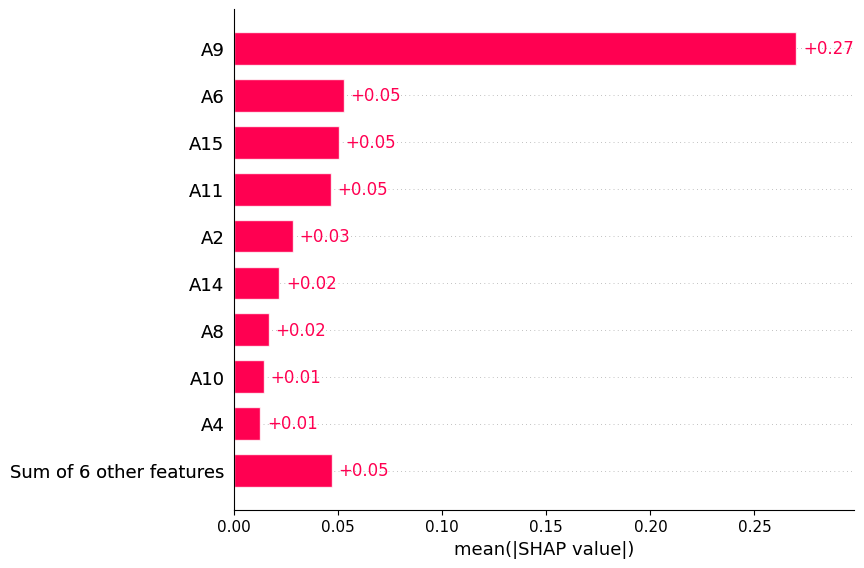

In [ ]:
shap.plots.bar(shap_values)

# Interpretability with SHAP Conclusion
It seems that the A9 category has the highest influence and A1, A4, A10, A12, A13, and A14 have very small influence.
After digging around, I believe (though I am not sure) that A9 represents marriage or employment status. Since being in a marriage and being employed are both things that might help one's financial status, it makes sense that they are highly influential in the credit approval process.

There is an (unfortunately intentional) bias in this data in which one of the features represents whether the subject is an unmarried female. In the case that the developer knows which feature this is and wants to lessen the influence of this feature, they can adjust the data by equalizing the training data in respect to positive and negative for that value and positive and negative credit approval. This would help improve the fairness of the machine learning model.